In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [2]:
d03 = xr.open_dataset('C:/Users/bente/Documents/BACKTRACK/backtracking/data/OO-2023.nc')       # all drifter data
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)             # drifter OO-2023-03

In [3]:
startlat = d03.lat.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values
startlon = d03.lon.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values

In [105]:
len(hits[0])

59

In [106]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")

14:20:06 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: C:/Users/bente/Documents/THESIS/Globcurrent/*.nc
14:20:06 INFO    opendrift.readers.reader_netCDF_CF_generic:131: Opening files with MFDataset
14:20:07 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
14:20:07 DEBUG   opendrift.readers.reader_netCDF_CF_generic:163: Parsing CF grid mapping dictionary: {'grid_mapping_name': 'latitude_longitude', 'semi_major_axis': 6378137, 'inverse_flattening': 298.257223563}
14:20:07 INFO    opendrift.readers.reader_netCDF_CF_generic:170: Could not parse CF grid_mapping
14:20:07 INFO    opendrift.readers.reader_netCDF_CF_generic:285: Grid coordinates are detected, but proj4 string not given: assuming latlong
14:20:07 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 6 for reader C:/Users/bente/Documents/THESIS/Globcurrent/*.nc, assuming a maximum average speed of 5 m/s and time span of 6:00:00
14:20:07 INFO    open

In [107]:
duration = timedelta(hours=288)                # 5 days
start_time = datetime(2023,2,2,3,12,8)
end_time = start_time + duration

In [108]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/bwd0214feb59.nc"

In [109]:
orev = OceanDrift(loglevel=50)
orev.add_reader([reader_globcur])
orev.set_config('drift:advection_scheme', 'runge-kutta4')
orev.set_config('drift:horizontal_diffusivity', 20)
orev.seed_elements(lon=startlon, lat=startlat, radius=10000, radius_type='uniform', number=100, time=end_time)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_bwd)

14:20:17 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.


In [110]:
back59 = xr.open_dataset(outfile_bwd)

In [24]:
# diflon = np.max(back.isel(time=120).lon.values) - np.min(back.isel(time=120).lon.values)
# diflat = np.max(back.isel(time=120).lat.values) - np.min(back.isel(time=120).lat.values)

In [9]:
end_time

datetime.datetime(2023, 2, 14, 3, 12, 8)

In [14]:
# # Define domain of possible origin !!! WITH RANDOM UNIFORM SEEDING !!!
# lons = np.zeros((120,120))
# lats = np.zeros((120,120))
# for j in range(120):
#     lons[j] = np.random.uniform(np.min(back.isel(time=120).lon.values)-(0.5), np.max(back.isel(time=120).lon.values)+(0.5), 120) # Much coarser CCC
#     lats[j] = np.random.uniform(np.min(back.isel(time=120).lat.values)-(0.5), np.max(back.isel(time=120).lat.values)+(0.5), 120)

In [15]:
# np.min(back.lat.values)

In [16]:
# np.max(back.lat.values)

In [29]:
# Set the desired grid size
grid_size_lon = 0.120  # Change this to your desired grid size
grid_size_lat = 0.100

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(np.min(back.isel(time=288).lon.values)-(0.5), np.max(back.isel(time=288).lon.values)+(0.5), grid_size_lon)
lat_bins = np.arange(np.min(back.isel(time=288).lat.values)-(0.5), np.max(back.isel(time=288).lat.values)+(0.5), grid_size_lat)

In [30]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [31]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*20)-20))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*20)-20))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*20):((j+1)*20)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 20) # Much coarser CCC
        lats[i][(j*20):((j+1)*20)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 20)

# FWD

In [32]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/fwd0214febdif2.nc"

In [33]:
ofwd = OceanDrift(loglevel=50)
ofwd.add_reader([reader_globcur])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')
ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time)
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)

In [34]:
fwd = xr.open_dataset(outfile)

In [36]:
len(fwd.trajectory)

36480

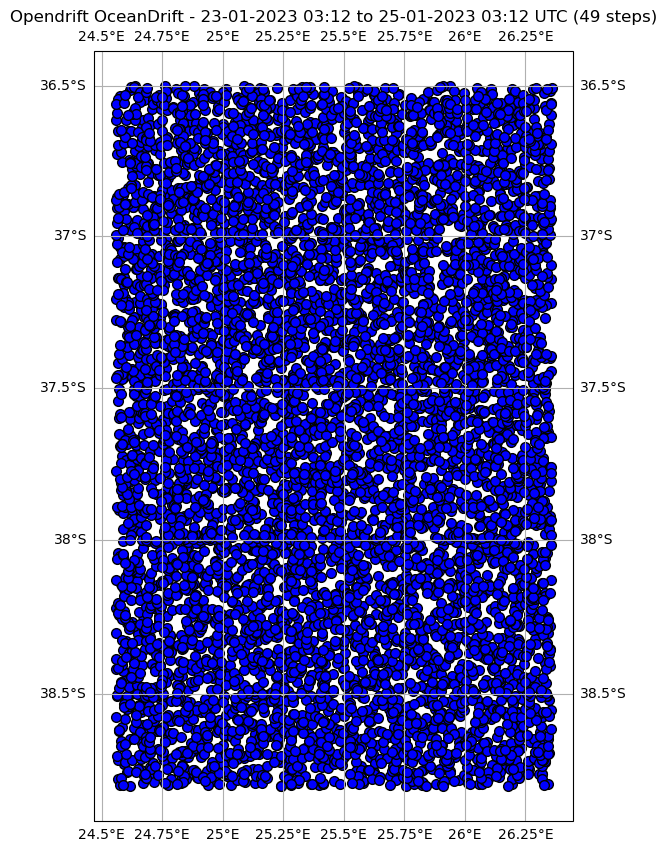

In [24]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

#fwd.traj.plot(linewidth=0.1)

for i in range(len(fwd.trajectory)):
    ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

#back.traj.plot(linewidth=0.1,color='red')

#d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-30 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

In [37]:
ilat = d03.lat.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values
ilon = d03.lon.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values

In [38]:
## FORWARD ## 
lon0 = []
lat0 = []
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        ### calculating hits ###
        lon0.append(fwd.isel(trajectory=j).lon.values)
        lat0.append(fwd.isel(trajectory=j).lat.values)
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
        
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(lonend0))
dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, ilon*on, ilat*on)
hits = np.where(dist2incident<10000)

hit_start_lons0= []
hit_start_lats0= []
for m in range(len(hits)):
        hit_start_lons0.append(lon0[hits[0][m]][0])
        hit_start_lats0.append(lat0[hits[0][m]][0])

In [ ]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 27-01-2023 03:12 UTC (49 steps)')
plt.show()

KeyboardInterrupt: 

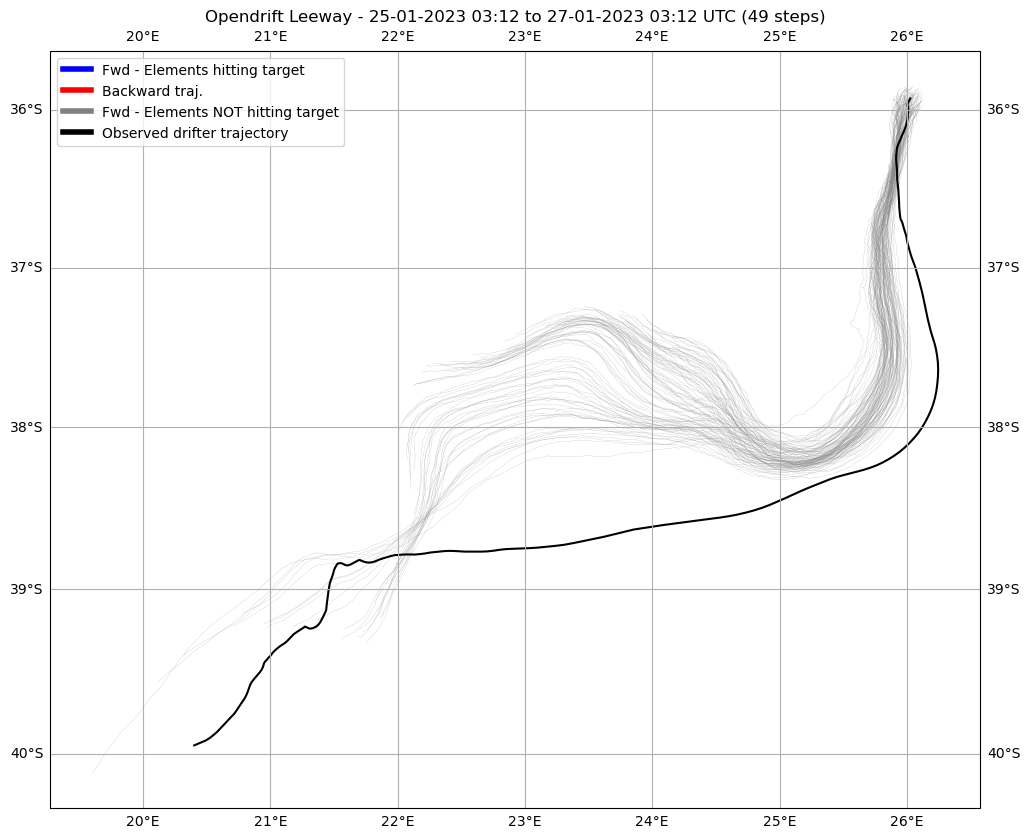

In [28]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(back.trajectory)):
    back.isel(trajectory=i).traj.plot(linewidth=0.1)
    
# for i in hits: 
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 27-01-2023 03:12 UTC (49 steps)')
plt.show()

In [39]:
len(hits[0])

59

In [40]:
o_hit = opendrift.open(outfile, elements=hits[0])

14:09:07 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
14:09:07 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
14:09:07 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
14:09:07 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
14:09:07 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
14:09:07 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
14:09:07 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/fwd0214febdif2.nc
14:09:13 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Settin

14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:surface_downward_y_stress -> None
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:surface_downward_y_stress -> 0
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_kinetic_energy -> None
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_kinetic_energy -> 0
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_generic_length_scale -> None
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_generic_length_scale -> 0
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:ocean_mixed_layer_thickness -> None
14:09:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:o

14:09:13 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=False, lscale=None
14:09:13 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (20.094058609008787, 26.5280403137207, -39.627299499511714, -35.64188079833984)..
14:09:31 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (20.094058609008787, 26.5280403137207, -39.627299499511714, -35.64188079833984)..
14:09:31 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (20.094058609008787, 26.5280403137207, -39.627299499511714, -35.64188079833984)..


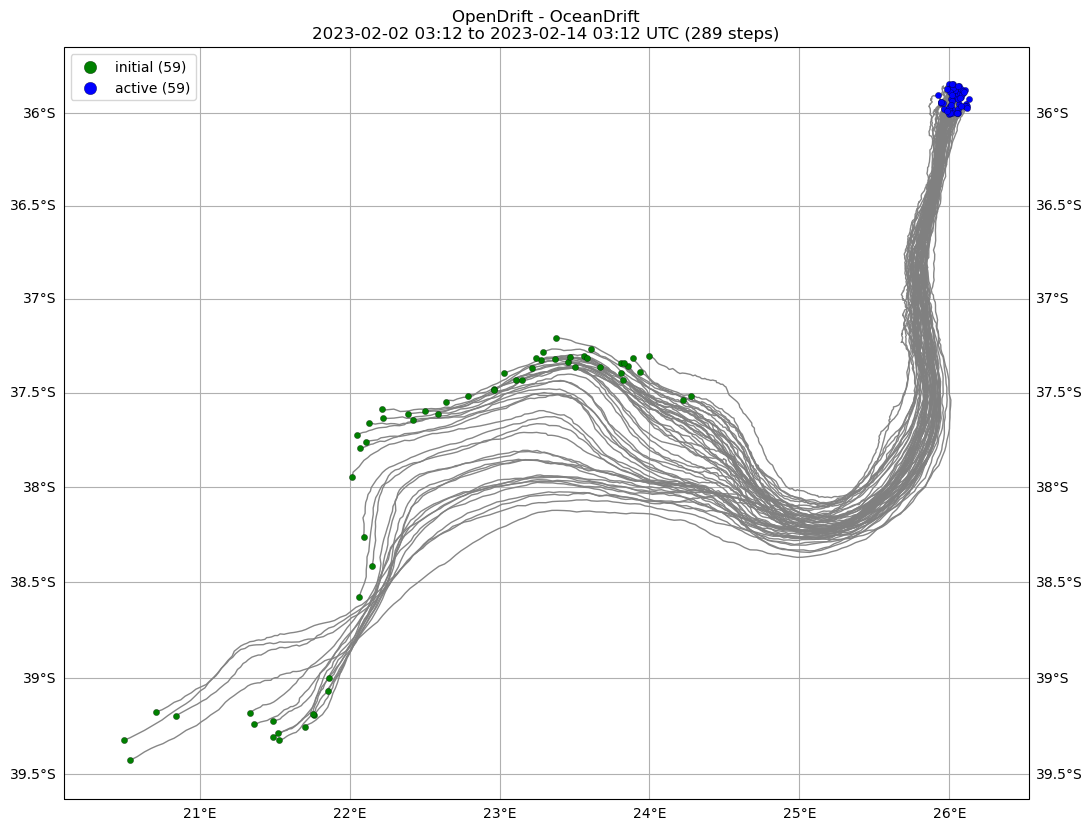

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 1 Axes>)

In [41]:
o_hit.plot()

14:09:32 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
14:09:33 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
14:09:33 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
14:09:33 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
14:09:33 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
14:09:33 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
14:09:33 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
14:09:33 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/oceandrift_48h/likelihood/fwd0214febdif2.nc
14:09:33 INFO    opendrift:118: Returning <class 'opendrift.models.oceandrift.OceanDrift'> object
14:09:33 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
14:09:37 DEBUG   opendrift.models.basemodel:3163: Setting up ma

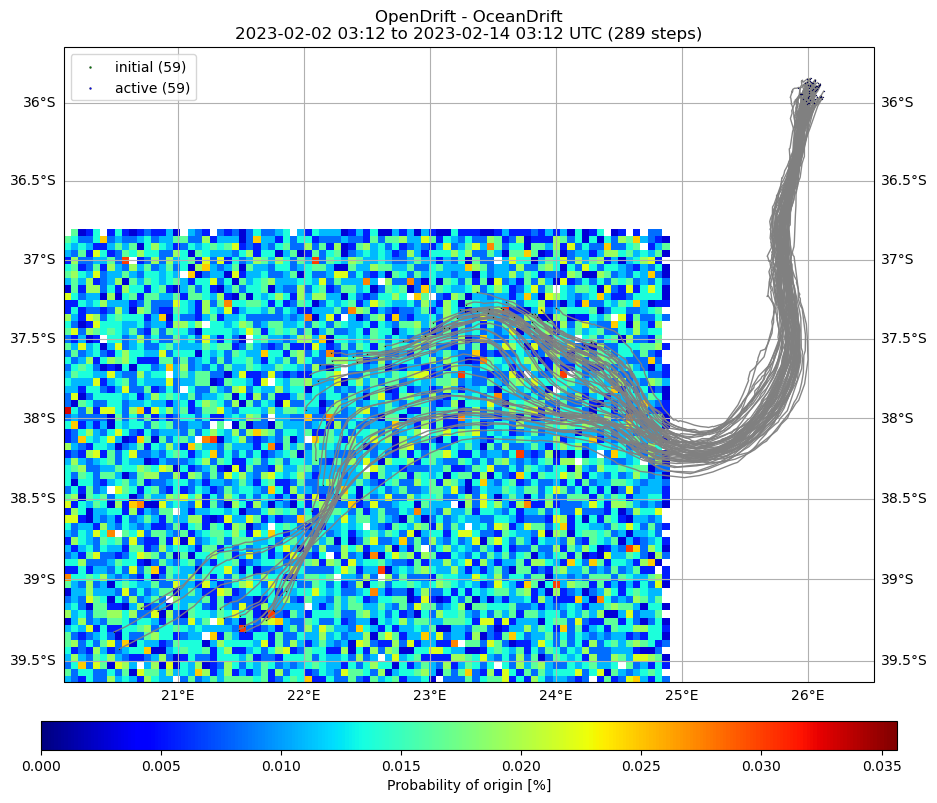

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [42]:
of = opendrift.open_xarray(outfile)
density_fwd = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_fwd = density_fwd.where(density_fwd>0)
density_fwd = density_fwd/density_fwd.sum()*100
vmax = density_fwd.max()
o_hit.plot(background=density_fwd, clabel='Probability of origin [%]', fast=True, markersize=.5, lalpha=.02, vmin=0)

In [43]:
# lonbin = np.arange(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), 0.025)
# latbin = np.arange(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), 0.025)

In [44]:
fwd = xr.open_dataset(outfile)

In [45]:
xfwd = fwd.isel(trajectory=hits[0])

#### Start lon and lat of FWD 'hits'

In [46]:
lon = []       # lon for 'hits'
lat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    lon.append(xfwd.isel(trajectory=i).lon.values[0])
    lat.append(xfwd.isel(trajectory=i).lat.values[0])

#### Start lon and lat of all FWD runs

In [47]:
lonall = []
latall = []

for i in range(len(fwd.trajectory)):
    lonall.append(fwd.isel(trajectory=i).lon.values[0])
    latall.append(fwd.isel(trajectory=i).lat.values[0])

In [48]:
# # Set the desired grid size
# grid_size_lon = 0.080  # Change this to your desired grid size
# grid_size_lat = 0.070

# # Calculate the number of grid cells in each dimension
# lon_bins = np.arange(np.min(lonall), np.max(lonall) + grid_size_lon, grid_size_lon)
# lat_bins = np.arange(np.min(latall), np.max(latall) + grid_size_lat, grid_size_lat)

In [49]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(lon, lat, lon_bins, lat_bins)

In [50]:
len(lon_bins)

49

14:13:37 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:13:37 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


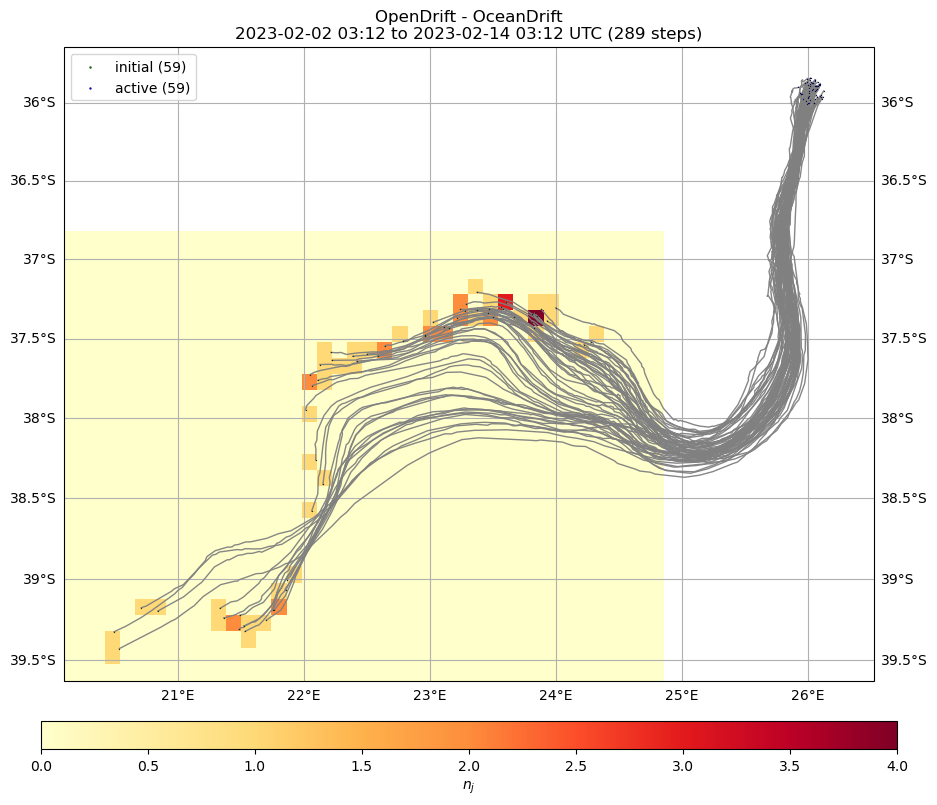

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [51]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

In [52]:
# Call the function to count points in grid cells
grid_counts_all = count_points_in_grid(lonall, latall, lon_bins, lat_bins)

14:13:41 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:13:41 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


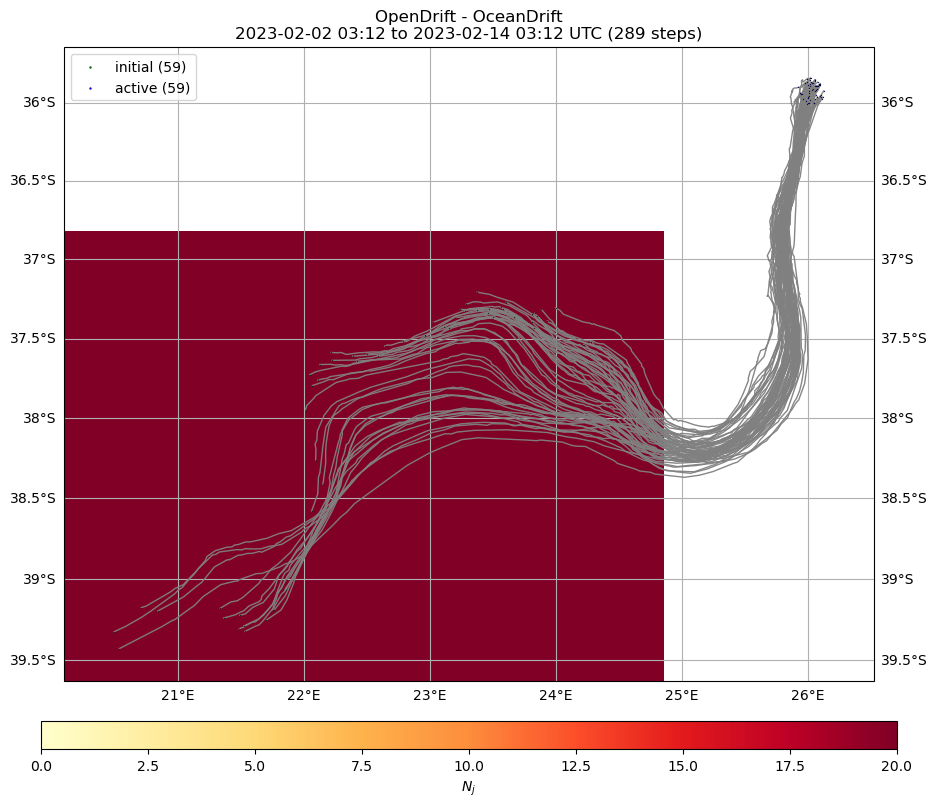

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [53]:
o_hit.plot(background=grid_counts_all, clabel='$N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

14:13:45 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:13:45 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


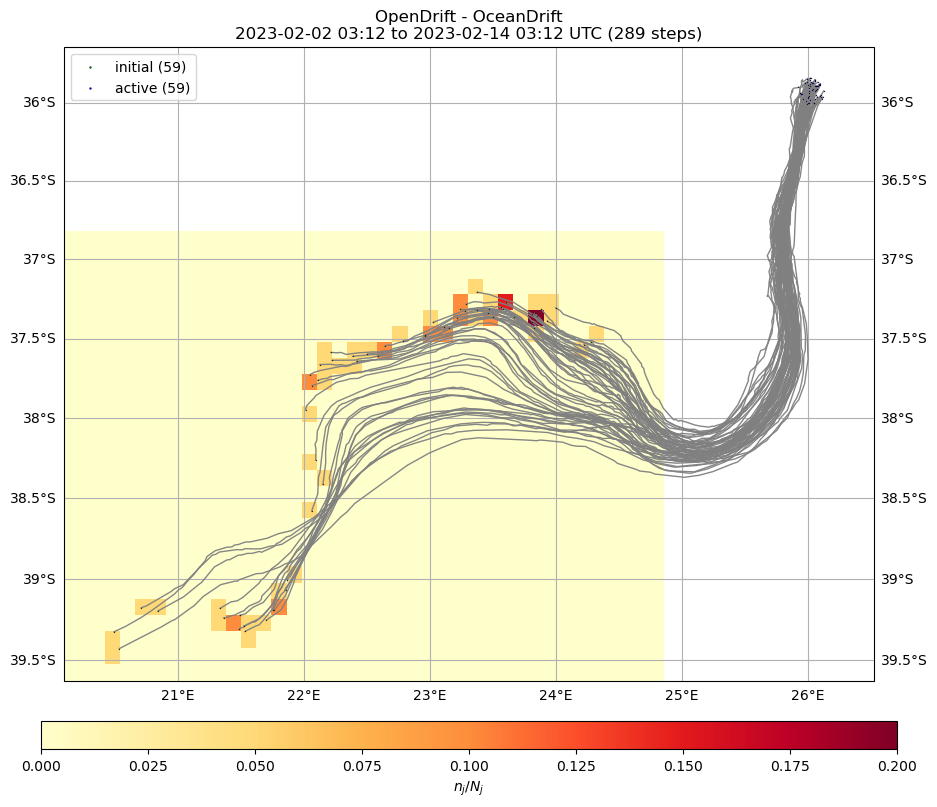

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [54]:
o_hit.plot(background=grid_counts/grid_counts_all, clabel='$n_j / N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

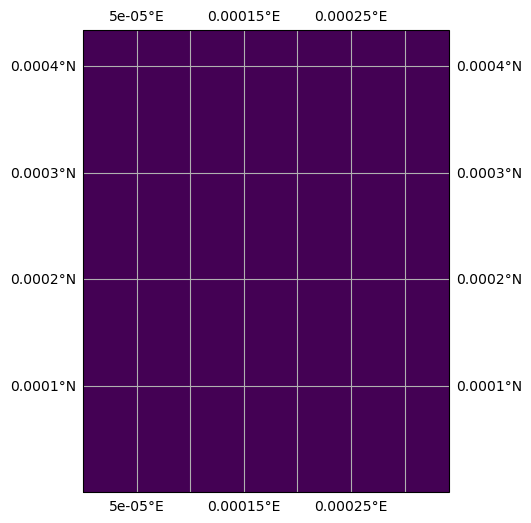

In [55]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.pcolormesh(grid_counts_all)

In [56]:
likelihood = grid_counts/grid_counts_all

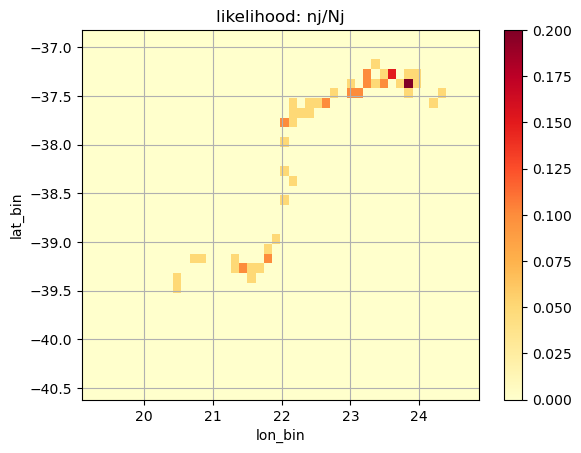

In [57]:
likelihood.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], cmap='YlOrRd')
plt.title('likelihood: nj/Nj')
plt.grid()

### Equal Prior Probability

In [58]:
prior = grid_counts_all/len(fwd.trajectory)

### Variable Prior Probability

Variable prior by LATITUDE:

In [59]:
varprior1 = (grid_counts_all[:,0:3]-4)
varprior2 = (grid_counts_all[:,3:7]+7)
varprior3 = (grid_counts_all[:,7:11]-4)

In [60]:
varprior = xr.concat([varprior1, varprior2,varprior3], dim='lat_bin')/len(fwd.trajectory)

Variable prior by LONGITUDE:

In [68]:
len(grid_counts_all)

48

In [95]:
varprior1 = (grid_counts_all[0:23]+(25/2)) 
varprior2 = (grid_counts_all[23:48]-(23/2))

In [96]:
varprior = xr.concat([varprior1, varprior2], dim='lon_bin')/len(fwd.trajectory)

Check if sum of all prior probabilities is 1!!!

In [97]:
np.sum(prior)

<xarray.DataArray ()>
array(1.)

In [98]:
np.sum(varprior)

<xarray.DataArray ()>
array(1.)

### Posterior (and norm. const.)

In [99]:
norm_const = len(hits)/len(fwd.trajectory)
posterior = (likelihood*prior)/norm_const

In [100]:
norm_const = len(hits)/len(fwd.trajectory)
varposterior = (likelihood*varprior)/norm_const

For equal prior:

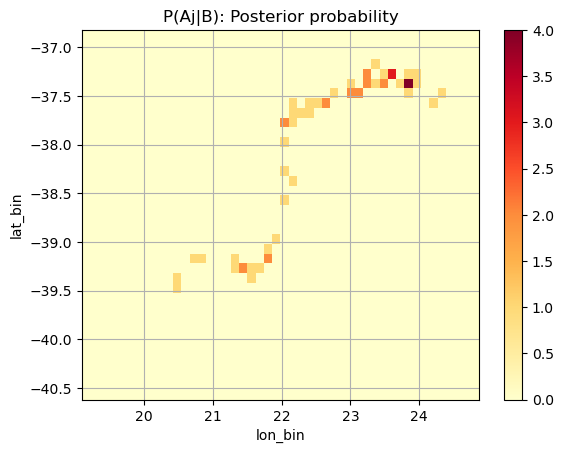

In [101]:
posterior.plot(x=posterior.dims[0], y=posterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()

For variable prior: 

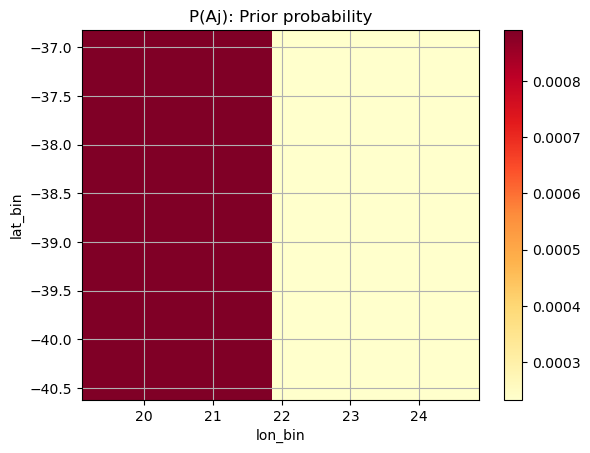

In [102]:
varprior.plot(x=varprior.dims[0], y=varprior.dims[1], cmap='YlOrRd')
plt.title('P(Aj): Prior probability')
plt.grid()

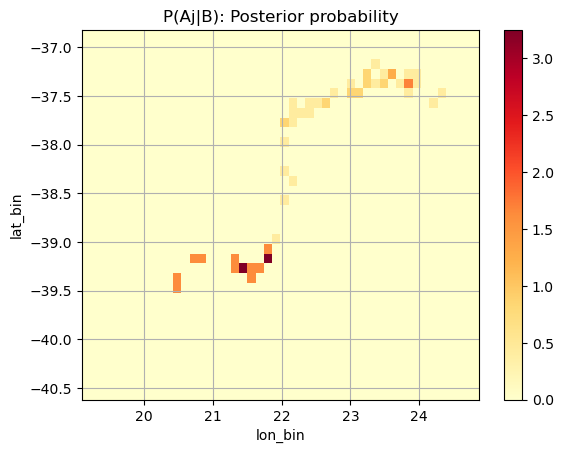

In [103]:
varposterior.plot(x=varposterior.dims[0], y=varposterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()

14:19:31 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:19:31 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


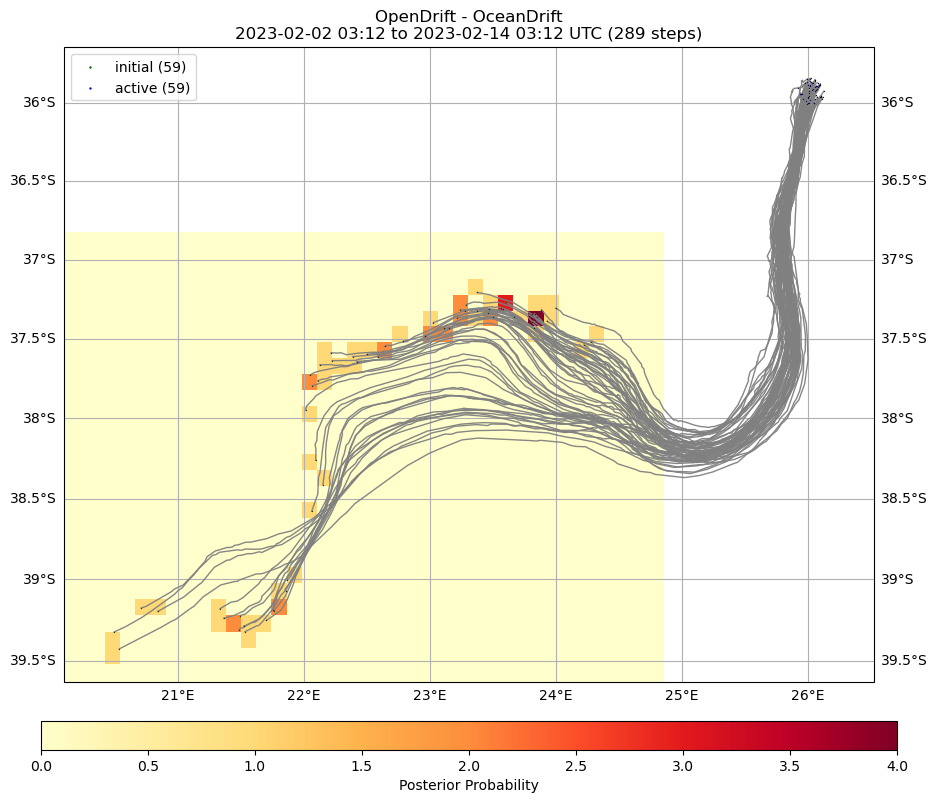

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [104]:
o_hit.plot(posterior, clabel='Posterior Probability', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

# BWD

In [111]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(back59.trajectory)):
    lonback.append(back59.isel(trajectory=i).lon.values[-1])
    latback.append(back59.isel(trajectory=i).lat.values[-1])

In [112]:
grid_counts_back = count_points_in_grid(lonback, latback, lon_bins, lat_bins)

In [113]:
o_back = opendrift.open(outfile_bwd)

14:21:36 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
14:21:36 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
14:21:36 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
14:21:37 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
14:21:37 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
14:21:37 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
14:21:37 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/bwd0214feb59.nc
14:21:37 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting 

14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:surface_downward_y_stress -> None
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:surface_downward_y_stress -> 0
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_kinetic_energy -> None
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_kinetic_energy -> 0
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_generic_length_scale -> None
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_generic_length_scale -> 0
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:ocean_mixed_layer_thickness -> None
14:21:37 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:o

14:21:41 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:21:41 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


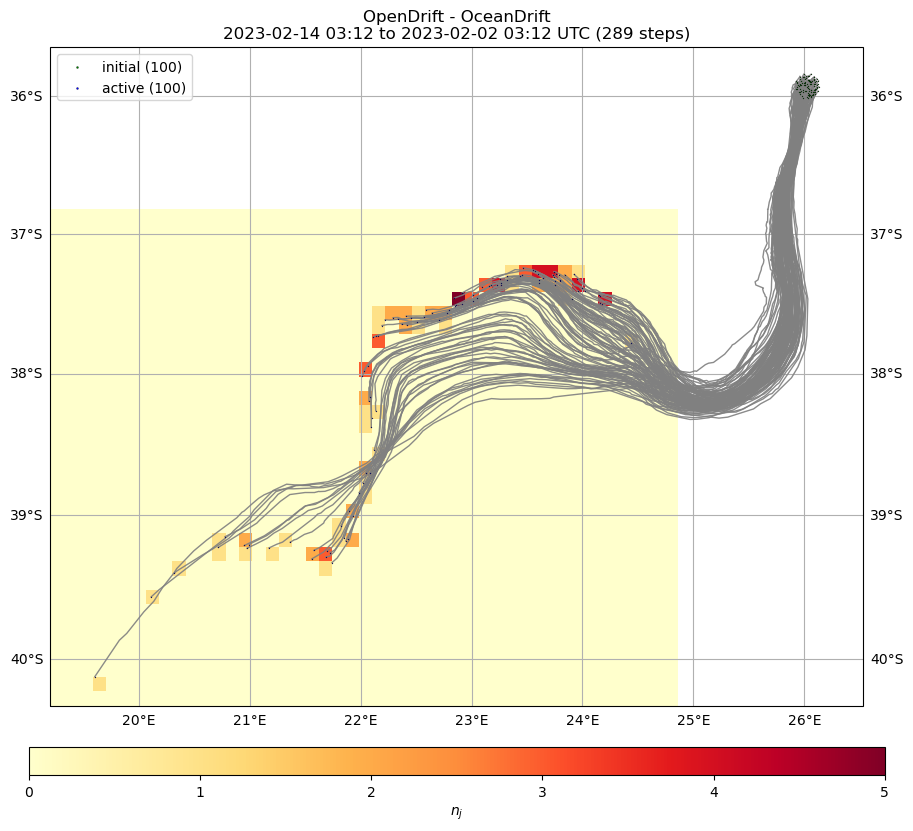

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-14 03:12 to 2023-02-02 03:12 UTC (289 steps)'}>,
 <Figure size 1100x891.355 with 2 Axes>)

In [114]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

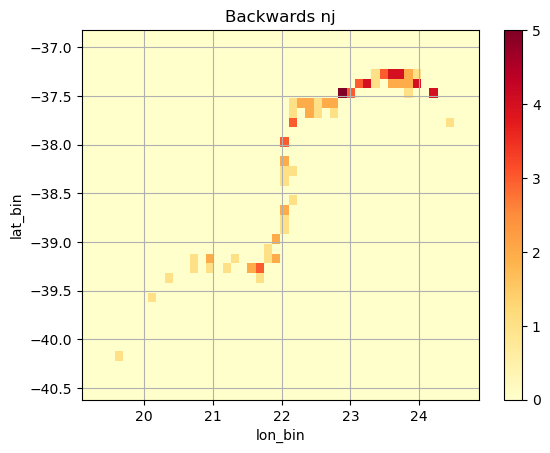

In [115]:
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.title('Backwards nj')
plt.grid()

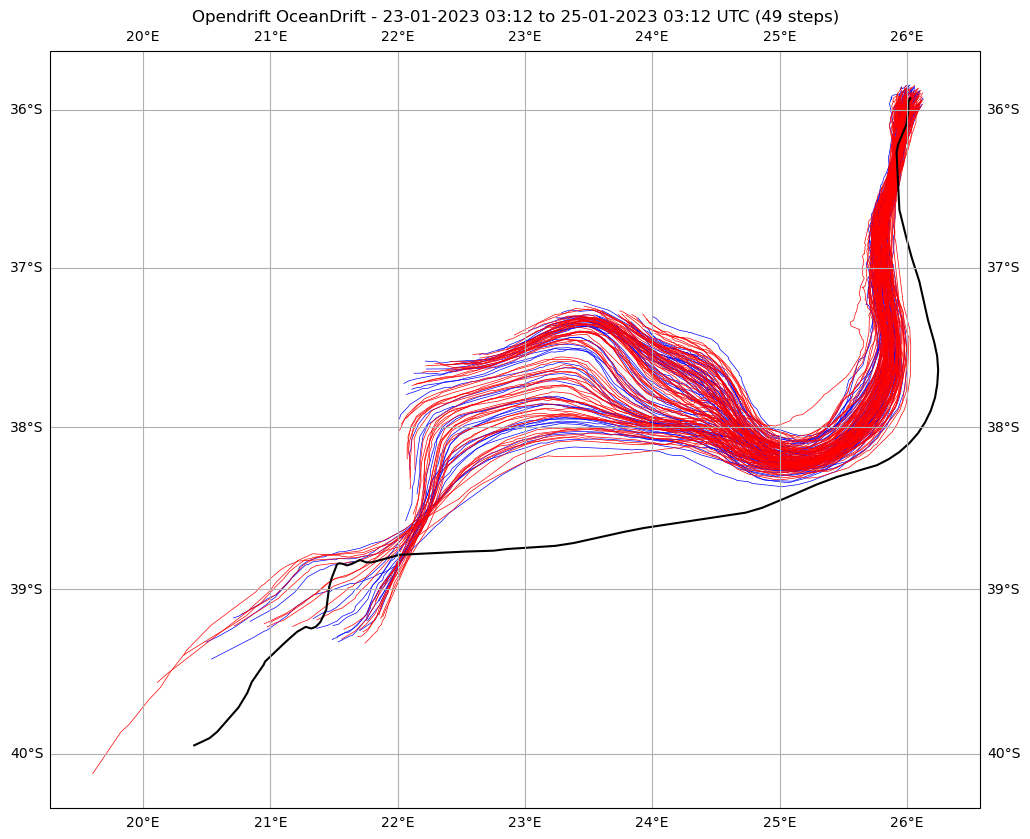

In [119]:
fig = plt.figure(1, figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')

back59.traj.plot(linewidth=0.5,color='red')

# ax.plot(back192.isel(time=0).lon.values, back192.isel(time=0).lat.values, 'ro', markersize=0.5, transform=ccrs.Geodetic())
# for i in hits: 
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', markersize=0.5, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

14:22:25 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:22:25 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


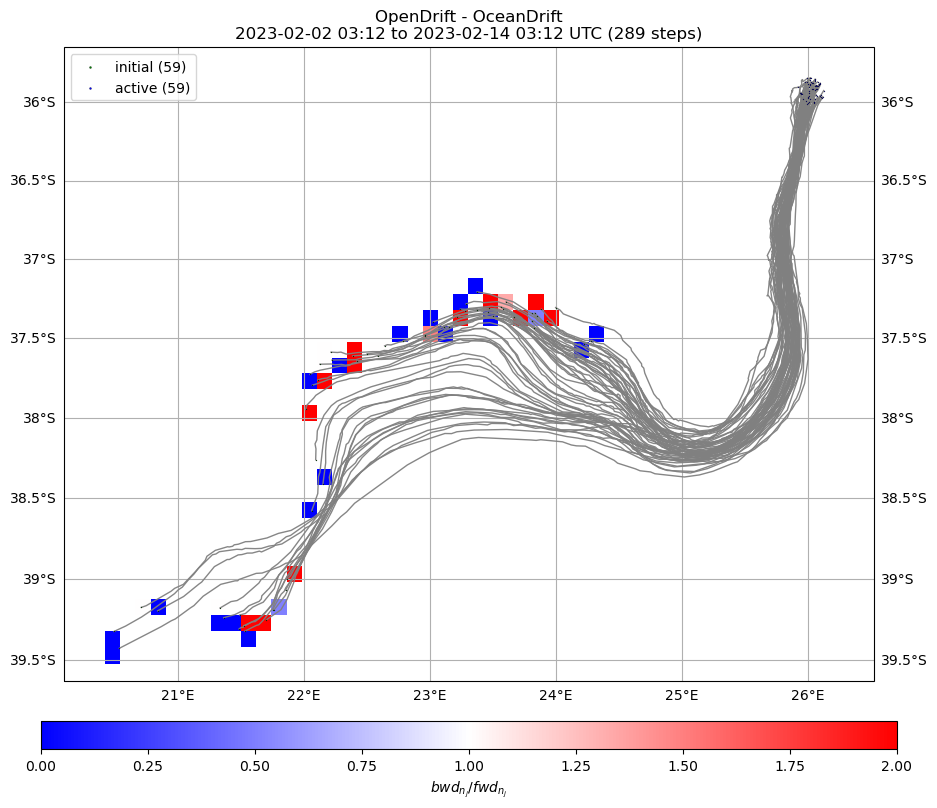

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x860.409 with 2 Axes>)

In [118]:
o_hit.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=2)

14:24:35 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
14:24:35 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


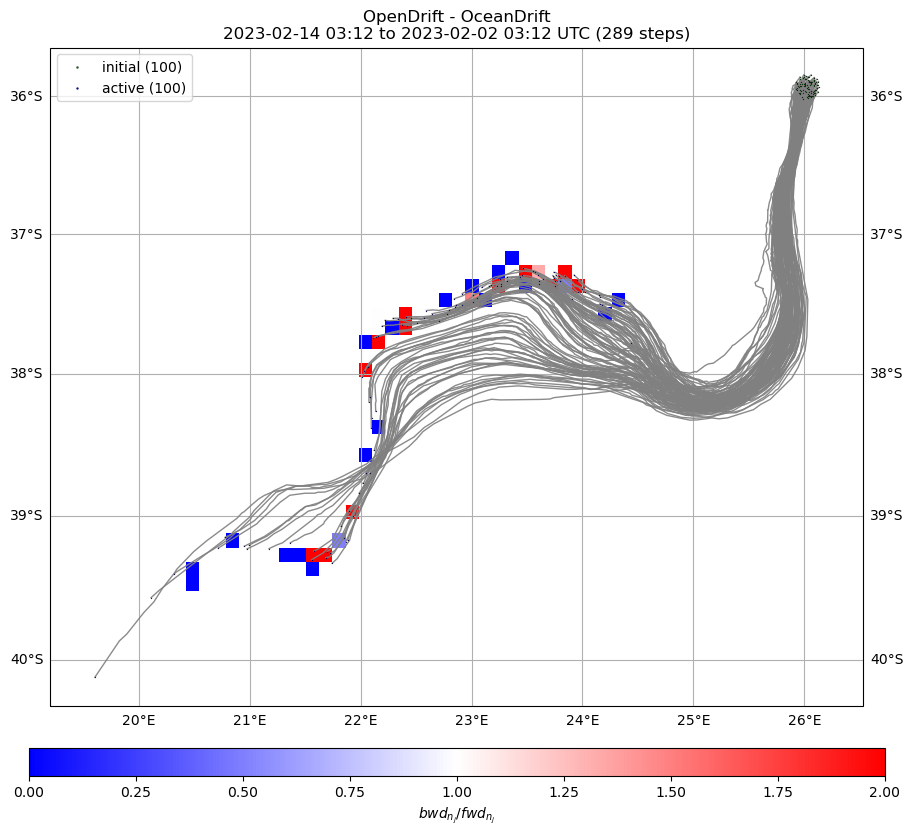

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-02-14 03:12 to 2023-02-02 03:12 UTC (289 steps)'}>,
 <Figure size 1100x891.355 with 2 Axes>)

In [120]:
o_back.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=2)